$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 1: Sequence Models
<a id=part1></a>

In this part we will learn about working with text sequences using recurrent neural networks.
We'll go from a raw text file all the way to a fully trained GRU-RNN model and generate works of art!

In [9]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Text generation with a char-level RNN
<a id=part1_1></a>

### Obtaining the corpus
<a id=part1_2></a>

Let's begin by downloading a corpus containing all the works of William Shakespeare.
Since he was very prolific, this corpus is fairly large and will provide us with enough data for
obtaining impressive results.

In [10]:
CORPUS_URL = 'https://github.com/cedricdeboom/character-level-rnn-datasets/raw/master/datasets/shakespeare.txt'
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

def download_corpus(out_path=DATA_DIR, url=CORPUS_URL, force=False):
    pathlib.Path(out_path).mkdir(exist_ok=True)
    out_filename = os.path.join(out_path, os.path.basename(url))
    
    if os.path.isfile(out_filename) and not force:
        print(f'Corpus file {out_filename} exists, skipping download.')
    else:
        print(f'Downloading {url}...')
        with urllib.request.urlopen(url) as response, open(out_filename, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        print(f'Saved to {out_filename}.')
    return out_filename
    
corpus_path = download_corpus()

Corpus file C:\Users\דידי\.pytorch-datasets\shakespeare.txt exists, skipping download.


Load the text into memory and print a snippet:

In [11]:
with open(corpus_path, 'r') as f:
    corpus = f.read()

print(f'Corpus length: {len(corpus)} chars')
print(corpus[7:1234])

Corpus length: 6347705 chars


ALLS WELL THAT ENDS WELL

by William Shakespeare

Dramatis Personae

  KING OF FRANCE
  THE DUKE OF FLORENCE
  BERTRAM, Count of Rousillon
  LAFEU, an old lord
  PAROLLES, a follower of Bertram
  TWO FRENCH LORDS, serving with Bertram

  STEWARD, Servant to the Countess of Rousillon
  LAVACHE, a clown and Servant to the Countess of Rousillon
  A PAGE, Servant to the Countess of Rousillon

  COUNTESS OF ROUSILLON, mother to Bertram
  HELENA, a gentlewoman protected by the Countess
  A WIDOW OF FLORENCE.
  DIANA, daughter to the Widow

  VIOLENTA, neighbour and friend to the Widow
  MARIANA, neighbour and friend to the Widow

  Lords, Officers, Soldiers, etc., French and Florentine  

SCENE:
Rousillon; Paris; Florence; Marseilles

ACT I. SCENE 1.
Rousillon. The COUNT'S palace

Enter BERTRAM, the COUNTESS OF ROUSILLON, HELENA, and LAFEU, all in black

  COUNTESS. In delivering my son from me, I bury a second husband.
  BERTRAM. And I in going, madam, weep o'

### Data Preprocessing
<a id=part1_3></a>

The first thing we'll need is to map from each unique character in the corpus to an index that will represent it in our learning process.

**TODO**: Implement the `char_maps()` function in the `hw3/charnn.py` module.

In [12]:
import hw3.charnn as charnn

char_to_idx, idx_to_char = charnn.char_maps(corpus)
print(char_to_idx)

test.assertEqual(len(char_to_idx), len(idx_to_char))
test.assertSequenceEqual(list(char_to_idx.keys()), list(idx_to_char.values()))
test.assertSequenceEqual(list(char_to_idx.values()), list(idx_to_char.keys()))

{'\n': 0, ' ': 1, '!': 2, '"': 3, '$': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '4': 16, '5': 17, '6': 18, '7': 19, '8': 20, '9': 21, ':': 22, ';': 23, '<': 24, '?': 25, 'A': 26, 'B': 27, 'C': 28, 'D': 29, 'E': 30, 'F': 31, 'G': 32, 'H': 33, 'I': 34, 'J': 35, 'K': 36, 'L': 37, 'M': 38, 'N': 39, 'O': 40, 'P': 41, 'Q': 42, 'R': 43, 'S': 44, 'T': 45, 'U': 46, 'V': 47, 'W': 48, 'X': 49, 'Y': 50, 'Z': 51, '[': 52, ']': 53, '_': 54, 'a': 55, 'b': 56, 'c': 57, 'd': 58, 'e': 59, 'f': 60, 'g': 61, 'h': 62, 'i': 63, 'j': 64, 'k': 65, 'l': 66, 'm': 67, 'n': 68, 'o': 69, 'p': 70, 'q': 71, 'r': 72, 's': 73, 't': 74, 'u': 75, 'v': 76, 'w': 77, 'x': 78, 'y': 79, 'z': 80, '}': 81, '»': 82, '¿': 83, 'ן': 84}


Seems we have some strange characters in the corpus that are very rare and are probably due to mistakes.
To reduce the length of each tensor we'll need to later represent our chars, it's best to remove them.

**TODO**: Implement the `remove_chars()` function in the `hw3/charnn.py` module.

In [13]:
corpus, n_removed = charnn.remove_chars(corpus, ['}','$','_','<','\ufeff'])
print(f'Removed {n_removed} chars')

# After removing the chars, re-create the mappings
char_to_idx, idx_to_char = charnn.char_maps(corpus)

Removed 33 chars


The next thing we need is an **embedding** of the chracters.
An embedding is a representation of each token from the sequence as a tensor.
For a char-level RNN, our tokens will be chars and we can thus use the simplest possible embedding: encode each char as a **one-hot** tensor. In other words, each char will be represented
as a tensor whos length is the total number of unique chars (`V`) which contains all zeros except at the index
corresponding to that specific char.

**TODO**: Implement the functions `chars_to_onehot()` and `onehot_to_chars()` in the `hw3/charnn.py` module.

In [14]:
# Wrap the actual embedding functions for calling convenience
def embed(text):
    return charnn.chars_to_onehot(text, char_to_idx)

def unembed(embedding):
    return charnn.onehot_to_chars(embedding, idx_to_char)

text_snippet = corpus[3104:3148]
print(text_snippet)
print(embed(text_snippet[0:3]))

test.assertEqual(text_snippet, unembed(embed(text_snippet)))
test.assertEqual(embed(text_snippet).dtype, torch.int8)

st brine a maiden can season her praise in.

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int8)


### Dataset Creation
<a id=part1_4></a>

We wish to train our model to generate text by constantly predicting what the next char should be based on the past.
To that end we'll need to train our recurrent network in a way similar to a classification task. At each timestep, we input a char and set the expected output (label) to be the next char in the original sequence.

We will split our corpus into shorter sequences of length `S` chars (try to think why; see question below).
Each **sample** we provide our model with will therefore be a tensor of shape `(S,V)` where `V` is the embedding dimension. Our model will operate sequentially on each char in the sequence.
For each sample, we'll also need a **label**. This is simple another sequence, shifted by one char so that the label of each char is the next char in the corpus.

**TODO**: Implement the `chars_to_labelled_samples()` function in the `hw3/charnn.py` module.

In [16]:
# Create dataset of sequences
seq_len = 64
vocab_len = len(char_to_idx)

# Create labelled samples
samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)
print(f'samples shape: {samples.shape}')
print(f'labels shape: {labels.shape}')

# Test shapes
num_samples = (len(corpus) - 1) // seq_len
test.assertEqual(samples.shape, (num_samples, seq_len, vocab_len))
test.assertEqual(labels.shape, (num_samples, seq_len))

# Test content
for _ in range(1000):
    # random sample
    i = np.random.randint(num_samples, size=(1,))[0]
    # Compare to corpus
    test.assertEqual(unembed(samples[i]), corpus[i*seq_len:(i+1)*seq_len], msg=f"content mismatch in sample {i}")
    # Compare to labels
    sample_text = unembed(samples[i])
    label_text = str.join('', [idx_to_char[j.item()] for j in labels[i]])
    test.assertEqual(sample_text[1:], label_text[0:-1], msg=f"label mismatch in sample {i}")
    
print(f'sample 100 as text:\n{unembed(samples[100])}')

RuntimeError: CUDA out of memory. Tried to allocate 490.38 MiB (GPU 0; 2.00 GiB total capacity; 515.35 MiB already allocated; 336.79 MiB free; 282.50 KiB cached)

As usual, instead of feeding one sample as a time into our model's forward we'll work with **batches** of samples. This means that at every timestep, our model will operate on a batch of chars that are from **different sequences**.
Effectively this will allow us to parallelize training our model by dong matrix-matrix multiplications
instead of matrix-vector during the forward pass.

Let's use the standard PyTorch `Dataset`/`DataLoader` combo. Luckily for the dataset we can use a built-in
class, `TensorDataset` to return tuples of `(sample, label)` from the `samples` and `labels` tensors we created above.

In [17]:
import torch.utils.data

# Create DataLoader returning batches of samples.
batch_size = 32

ds_corpus = torch.utils.data.TensorDataset(samples, labels)
dl_corpus = torch.utils.data.DataLoader(ds_corpus, batch_size=batch_size, shuffle=False)

Let's see what that gives us:

In [18]:
print(f'num batches: {len(dl_corpus)}')

x0, y0 = next(iter(dl_corpus))
print(f'shape of a batch sample: {x0.shape}')
print(f'shape of a batch label: {y0.shape}')

num batches: 3100
shape of a batch sample: torch.Size([32, 64, 81])
shape of a batch label: torch.Size([32, 64])


### Model Implementation
<a id=part1_5></a>

Finally, our data set is ready so we can focus on our model.

We'll implement here is a multilayer gated recurrent unit (GRU) model, with dropout.
This model is a type of RNN which performs similar to the well-known LSTM model,
but it's somewhat easier to train because it has less parameters.
We'll modify the regular GRU slightly by applying dropout to
the hidden states passed between layers of the model.

The model accepts an input $\mat{X}\in\set{R}^{S\times V}$ containing a sequence of embedded chars.
It returns an output $\mat{Y}\in\set{R}^{S\times V}$ of predictions for the next char and the final hidden state
$\mat{H}\in\set{R}^{L\times H}$. Here $S$ is the sequence length, $V$ is the vocabulary size (number of unique chars), $L$ is the number of layers in the model and $H$ is the hidden dimension.

Mathematically, the model's forward function at layer $k\in[1,L]$ and timestep $t\in[1,S]$ can be described as

$$
\begin{align}
\vec{z_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xz}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hz}}}^{[k]} + \vec{b}_{\mathrm{z}}^{[k]}\right) \\
\vec{r_t}^{[k]} &= \sigma\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xr}}}^{[k]} +
    \vec{h}_{t-1}^{[k]} {\mattr{W}_{\mathrm{hr}}}^{[k]} + \vec{b}_{\mathrm{r}}^{[k]}\right) \\
\vec{g_t}^{[k]} &= \tanh\left(\vec{x}^{[k]}_t {\mattr{W}_{\mathrm{xg}}}^{[k]} +
    (\vec{r_t}^{[k]}\odot\vec{h}_{t-1}^{[k]}) {\mattr{W}_{\mathrm{hg}}}^{[k]} + \vec{b}_{\mathrm{g}}^{[k]}\right) \\
\vec{h_t}^{[k]} &= \vec{z}^{[k]}_t \odot \vec{h}^{[k]}_{t-1} + \left(1-\vec{z}^{[k]}_t\right)\odot \vec{g_t}^{[k]}
\end{align}
$$

The input to each layer is,
$$
\mat{X}^{[k]} =
\begin{bmatrix}
    {\vec{x}_1}^{[k]} \\ \vdots \\ {\vec{x}_S}^{[k]}
\end{bmatrix} 
=
\begin{cases}
    \mat{X} & \mathrm{if} ~k = 1~ \\
    \mathrm{dropout}_p \left(
    \begin{bmatrix}
        {\vec{h}_1}^{[k-1]} \\ \vdots \\ {\vec{h}_S}^{[k-1]}
    \end{bmatrix} \right) & \mathrm{if} ~1 < k \leq L+1~
\end{cases}.
$$

The output of the entire model is then,
$$
\mat{Y} = \mat{X}^{[L+1]} {\mattr{W}_{\mathrm{hy}}} + \mat{B}_{\mathrm{y}}
$$

and the final hidden state is
$$
\mat{H} = 
\begin{bmatrix}
    {\vec{h}_S}^{[1]} \\ \vdots \\ {\vec{h}_S}^{[L]}
\end{bmatrix}.
$$

Notes:
- $t\in[1,S]$ is the timestep, i.e. the current position within the sequence of each sample.
- $\vec{x}_t^{[k]}$ is the input of layer $k$ at timestep $t$, respectively.
- The outputs of the **last layer** $\vec{y}_t^{[L]}$, are the predicted next characters for every input char.
  These are similar to class scores in classification tasks.
- The hidden states at the **last timestep**, $\vec{h}_S^{[k]}$, are the final hidden state returned from the model.
- $\sigma(\cdot)$ is the sigmoid function, i.e. $\sigma(\vec{z}) = 1/(1+e^{-\vec{z}})$ which returns values in $(0,1)$.
- $\tanh(\cdot)$ is the hyperbolic tangent, i.e. $\tanh(\vec{z}) = (e^{2\vec{z}}-1)/(e^{2\vec{z}}+1)$ which returns values in $(-1,1)$.
- $\vec{h_t}^{[k]}$ is the hidden state of layer $k$ at time $t$. This can be thought of as the memory of that layer.
- $\vec{g_t}^{[k]}$ is the candidate hidden state for time $t+1$.
- $\vec{z_t}^{[k]}$ is known as the update gate. It combines the previous state with the input to determine how much the current state will be combined with the new candidate state. For example, if $\vec{z_t}^{[k]}=\vec{1}$ then the current input has no effect on the output.
- $\vec{r_t}^{[k]}$ is known as the reset gate. It combines the previous state with the input to determine how much of the previous state will affect the current state candidate. For example if $\vec{r_t}^{[k]}=\vec{0}$ the previous state has no effect on the current candidate state.

Here's a graphical representation of the GRU's forward pass at each timestep. The $\vec{\tilde{h}}$ in the image is our $\vec{g}$ (candidate next state).

<img src="imgs/gru_cell.png" width="400"/>

You can see how the reset and update gates allow the model to completely ignore it's previous state, completely ignore it's input, or any mixture of those states (since the gates are actually continuous and between $(0,1)$).

Here's a graphical representation of the entire model.
You can ignore the $c_t^{[k]}$ (cell state) variables (which are relevant for LSTM models).
Our model has only the hidden state, $h_t^{[k]}$. Also notice that we added dropout between layers (the up arrows).

<img src="imgs/lstm_model.png"/>

The purple tensors are inputs (a sequence and initial hidden state per layer), and the green tensors are outputs (another sequence and final hidden state per layer). Each blue block implements the above forward equations.
Blocks that are on the same vertical level are at the same layer, and therefore share parameters.

**TODO**: Implement the `MultilayerGRU` class in the `hw3/charnn.py` module.

Notes:
- You'll need to handle input **batches** now.
  The math is identical to the above, but all the tensors will have an extra batch
  dimension as their first dimension.
- Use the diagram above to help guide your implementation.
  It will help you visualize what shapes to returns where, etc.


In [19]:
in_dim = vocab_len
h_dim = 256
n_layers = 2
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers)
model = model.to(device)
print(model)

# Test forward pass
y, h = model(x0.to(dtype=torch.float))
print(f'y.shape={y.shape}')
print(f'h.shape={h.shape}')

test.assertEqual(y.shape, (batch_size, seq_len, vocab_len))
test.assertEqual(h.shape, (batch_size, n_layers, h_dim))
test.assertEqual(len(list(model.parameters())), 9 * n_layers + 2) 

MultilayerGRU(
  (dropout): Dropout(p=0)
  (W_x_z_0): Linear(in_features=81, out_features=256, bias=False)
  (W_h_z_0): Linear(in_features=256, out_features=256, bias=True)
  (W_x_r_0): Linear(in_features=81, out_features=256, bias=False)
  (W_h_r_0): Linear(in_features=256, out_features=256, bias=True)
  (W_x_g_0): Linear(in_features=81, out_features=256, bias=False)
  (W_h_g_0): Linear(in_features=256, out_features=256, bias=True)
  (W_x_z_1): Linear(in_features=256, out_features=256, bias=False)
  (W_h_z_1): Linear(in_features=256, out_features=256, bias=True)
  (W_x_r_1): Linear(in_features=256, out_features=256, bias=False)
  (W_h_r_1): Linear(in_features=256, out_features=256, bias=True)
  (W_x_g_1): Linear(in_features=256, out_features=256, bias=False)
  (W_h_g_1): Linear(in_features=256, out_features=256, bias=True)
  (W_h_y): Linear(in_features=256, out_features=81, bias=True)
)
y.shape=torch.Size([32, 64, 81])
h.shape=torch.Size([32, 2, 256])


### Generating text by sampling
<a id=part1_6></a>

Now that we have a model, we can implement **text generation** based on it.
The idea is simple:
At each timestep our model receives one char $x_t$ from the input sequence and outputs scores $y_t$
for what the next char should be.
We'll convert these scores into a probability over each of the possible chars.
In other words, for each input char $x_t$ we create a probability distribution for the next char
conditioned on the current one and the state of the model (representing all previous inputs):
$$p(x_{t+1}|x_t; \vec{h}_t).$$

Once we have such a distribution, we'll sample a char from it.
This will be the first char of our generated sequence.
Now we can feed this new char into the model, create another distribution, sample the next char and so on.
Note that it's crucial to propagate the hidden state when sampling.

The important point however is how to create the distribution from the scores.
One way, as we saw in previous ML tasks, is to use the softmax function.
However, a drawback of softmax is that it can generate very diffuse (more uniform) distributions if the score values are very similar. When sampling, we would prefer to control the distributions and make them less uniform to increase the chance of sampling the char(s) with the highest scores compared to the others.

To control the variance of the distribution, a common trick is to add a hyperparameter $T$, known as the 
*temperature* to the softmax function. The class scores are simply scaled by $T$ before softmax is applied:
$$
\mathrm{softmax}_T(\vec{y}) = \frac{e^{\vec{y}/T}}{\sum_k e^{y_k/T}}
$$

A low $T$ will result in less uniform distributions and vice-versa.

**TODO**: Implement the `hot_softmax()` function in the `hw3/charnn.py` module.

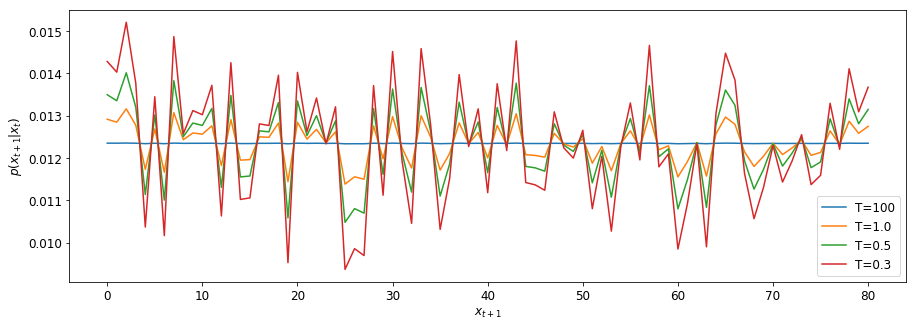

In [20]:
scores = y[0,0,:].detach()
_, ax = plt.subplots(figsize=(15,5))

for t in reversed([0.3, 0.5, 1.0, 100]):
    ax.plot(charnn.hot_softmax(scores, temperature=t).cpu().numpy(), label=f'T={t}')
ax.set_xlabel('$x_{t+1}$')
ax.set_ylabel('$p(x_{t+1}|x_t)$')
ax.legend()

uniform_proba = 1/len(char_to_idx)
uniform_diff = torch.abs(charnn.hot_softmax(scores, temperature=100) - uniform_proba)
test.assertTrue(torch.all(uniform_diff < 1e-4))

**TODO**: Implement the `generate_from_model()` function in the `hw3/charnn.py` module.

In [21]:
for _ in range(3):
    text = charnn.generate_from_model(model, "foobar", 50, (char_to_idx, idx_to_char), T=0.5)
    print(text)
    test.assertEqual(len(text), 50)

foobarkxhOiEGKcy2c9PGpaKS4Go&rjGmps
5n:?VGNtnUFqjo
foobarAP)xn)oJ8CYujPןu MS]W WWYdMcTXmLa;BpaJfJ)[zR
foobarןUqKeD(2UDs!;IJ¿Nu74Y1&v"d[N?)J¿VB!v
(lrO;nX


### Training
<a id=part1_7></a>

To train such a model, we'll calculate the loss at each time step by comparing the predicted char to
the actual char from our label. We can use cross entropy since per char it's similar to a classification problem.
We'll then sum the losses over the sequence and back-propagate the gradients though time.
Notice that the back-propagation algorithm will "visit" each layer's parameter tensors multiple times,
so we'll accumulate gradients in parameters of the blocks. Luckily `autograd` will handle this part for us.

As usual, the first step of training will be to try and **overfit** a large model (many parameters) to a tiny dataset.
Again, this is to ensure the model and training code are implemented correctly, i.e. that the model can learn.

For a generative model such as this, overfitting is slightly trickier than for for classification.
What we'll aim to do is to get our model to **memorize** a specific sequence of chars, so that when given the first
char in the sequence it will immediately spit out the rest of the sequence verbatim.

Let's create a tiny dataset to memorize.

In [22]:
# Pick a tiny subset of the dataset
subset_start, subset_end = 1001, 1005
ds_corpus_ss = torch.utils.data.Subset(ds_corpus, range(subset_start, subset_end))
dl_corpus_ss = torch.utils.data.DataLoader(ds_corpus_ss, batch_size=1, shuffle=False)

# Convert subset to text
subset_text = ''
for i in range(subset_end - subset_start):
    subset_text += unembed(ds_corpus_ss[i][0])
print(f'Text to "memorize":\n\n{subset_text}')

Text to "memorize":

BERTRAM. What would you have?
  HELENA. Something; and scarce so much; nothing, indeed.
    I would not tell you what I would, my lord.
    Faith, yes:
    Strangers and foes do sunder and not kiss.
  BERTRAM. I pray you, stay not, but in haste to horse.
 


Now let's implement the first part of our training code.

**TODO**: Implement the `train_epoch()` and `train_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module. 
Note: Think about how to correctly handle the hidden state of the model between batches and epochs
(for this specific task, i.e. text generation).

In [45]:
import torch.nn as nn
import torch.optim as optim
from hw3.training import RNNTrainer

torch.manual_seed(42)

lr = 0.01
num_epochs = 500

in_dim = vocab_len
h_dim = 128
n_layers = 2
loss_fn = nn.CrossEntropyLoss()
model = charnn.MultilayerGRU(in_dim, h_dim, out_dim=in_dim, n_layers=n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

for epoch in range(num_epochs):
    epoch_result = trainer.train_epoch(dl_corpus_ss, verbose=False)
    
    # Every X epochs, we'll generate a sequence starting from the first char in the first sequence
    # to visualize how/if/what the model is learning.
    if epoch == 0 or (epoch+1) % 25 == 0:
        avg_loss = np.mean(epoch_result.losses)
        accuracy = np.mean(epoch_result.accuracy)
        print(f'\nEpoch #{epoch+1}: Avg. loss = {avg_loss:.3f}, Accuracy = {accuracy:.2f}%')
        
        generated_sequence = charnn.generate_from_model(model, subset_text[0],
                                                        seq_len*(subset_end-subset_start),
                                                        (char_to_idx,idx_to_char), T=0.1)
        # Stop if we've successfully memorized the small dataset.
        print(generated_sequence)
        if generated_sequence == subset_text:
            break

# Test successful overfitting
test.assertGreater(epoch_result.accuracy, 99)
test.assertEqual(generated_sequence, subset_text)

OK, so training works - we can memorize a short sequence. Next on the agenda is to split our full dataset into a training and test sets of batched sequences.

In [ ]:
# Full dataset definition
vocab_len = len(char_to_idx)
seq_len = 64
batch_size = 256
train_test_ratio = 0.9
num_samples = (len(corpus) - 1) // seq_len
num_train = int(train_test_ratio * num_samples)

samples, labels = charnn.chars_to_labelled_samples(corpus, char_to_idx, seq_len, device)

ds_train = torch.utils.data.TensorDataset(samples[:num_train], labels[:num_train])
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=False, drop_last=True)

ds_test = torch.utils.data.TensorDataset(samples[num_train:], labels[num_train:])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, drop_last=True)

print(f'Train: {len(dl_train):3d} batches, {len(dl_train)*batch_size*seq_len:7d} chars')
print(f'Test:  {len(dl_test):3d} batches, {len(dl_test)*batch_size*seq_len:7d} chars')

We'll now train a much larger model on our large dataset.
You'll need a **GPU** for this part.

The code blocks below will train the model and save checkpoints containing the training state and the best model parameters to a file. This allows you to stop training and resume it later from where you left.

Note that you can use the `main.py` script provided within the assignment folder to run this notebook from the command line as if it were a python script by using the `run-nb` subcommand. This allows you to train your model using this notebook without starting jupyter. You can combine this with `srun` or `sbatch` to run the notebook with a GPU on the course servers.

In [ ]:
# Full training definition
lr = 0.001
num_epochs = 50

in_dim = out_dim = vocab_len
hidden_dim = 512
n_layers = 3
dropout = 0.5
checkpoint_file = 'checkpoints/rnn'
max_batches = 300
early_stopping = 5

model = charnn.MultilayerGRU(in_dim, hidden_dim, out_dim, n_layers, dropout)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
trainer = RNNTrainer(model, loss_fn, optimizer, device)

**TODO**:
- Implement the `fit()` method of the `Trainer` class. You can reuse the implementation from HW2, but make sure to implement early stopping and checkpoints.
- Implement the `test_epoch()` and `test_batch()` methods of the `RNNTrainer` class in the `hw3/training.py` module.
- Run the following block to train.

In [ ]:
from cs236605.plot import plot_fit

def post_epoch_fn(epoch, test_res, train_res, verbose):
    # Update learning rate
    scheduler.step(test_res.accuracy)
    # Sample from model to show progress
    if verbose:
        start_seq = "ACT I."
        generated_sequence = charnn.generate_from_model(
            model, start_seq, 100, (char_to_idx,idx_to_char), T=0.5
        )
        print(generated_sequence)

# Train, unless final checkpoint is found
checkpoint_file_final = f'{checkpoint_file}_final.pt'
if os.path.isfile(checkpoint_file_final):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    saved_state = torch.load(checkpoint_file_final, map_location=device)
    model.load_state_dict(saved_state['model_state'])
else:
    try:
        # Print pre-training sampling
        print(charnn.generate_from_model(model, "ACT I.", 100, (char_to_idx,idx_to_char), T=0.5))

        fit_res = trainer.fit(dl_train, dl_test, num_epochs, max_batches=max_batches,
                              post_epoch_fn=post_epoch_fn, early_stopping=early_stopping,
                              checkpoints=checkpoint_file, print_every=1)
        
        fig, axes = plot_fit(fit_res)
    except KeyboardInterrupt as e:
        print('\n *** Training interrupted by user')

### Generating a work of art
<a id=part1_8></a>

Armed with our fully trained model, let's generate the next Hamlet! You should experiment with modifying the sampling temperature and see what happens.

**TODO**: Specify the generation parameters in the `part1_generation_params()` function within the `hw3/answers.py` module.

In [ ]:
import hw3.answers

start_seq, temperature = hw3.answers.part1_generation_params()

generated_sequence = charnn.generate_from_model(
    model, start_seq, 10000, (char_to_idx,idx_to_char), T=temperature
)

print(generated_sequence)

## Questions
<a id=part1_9></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [ ]:
from cs236605.answers import display_answer
import hw3.answers

### Question 1
Why do we split the corpus into sequences instead of training on the whole text?

In [ ]:
display_answer(hw3.answers.part1_q1)

### Question 2
How is it possible that the generated text clearly shows memory longer than the sequence length?

In [ ]:
display_answer(hw3.answers.part1_q2)

### Question 3
Why are we not shuffling the order of batches when training?

In [ ]:
display_answer(hw3.answers.part1_q3)

### Question 4
1. Why do we lower the temperature for sampling (compared to the default of $1.0$ when training)?
2. What happens when the temperature is very high and why?
3. What happens when the temperature is very low and why?

In [ ]:
display_answer(hw3.answers.part1_q4)